<table>
        <tr>
          <th>Name<br></th>
          <th>URL</th>
        </tr>
        <tr>
          <td>Jupyter notebook on spark-master (get token from terminal)</td>
          <td><a href="http://localhost:8888">http://localhost:8888</a></td>
        </tr>
        <tr>
          <td>Spark Master Web UI - Overall</td>
          <td><a href="http://localhost:8080">http://localhost:8080</a></td>
        </tr>
        <tr>
          <td>Spark Master Web UI - App (when an app is running)</td>
          <td><a href="http://localhost:4040">http://localhost:4040</a></td>
        </tr>
        <tr>
          <td>Spark Worker Web UI (only when enabled)</td>
          <td><a href="http://localhost:8081">http://localhost:8081</a></td>
        </tr>
      </table>

In [3]:
import os
import json
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from pyspark.ml.feature import Bucketizer
# import pyspark
# import pyspark.sql.functions as fn
# from pyspark.sql import SparkSession

In [2]:
spark_master = 'spark://{}:{}'.format(os.environ['SPARK_MASTER_HOST'],
                                    os.environ['SPARK_MASTER_PORT'])
print(spark_master)

spark://spark-master:7077


In [3]:
spark = (SparkSession.builder
         .master(spark_master)
         .appName('my_app')
         .getOrCreate())

In [4]:
ND = np.ndarray
DF = pd.DataFrame
S = pd.Series
# SDF = pyspark.sql.DataFrame

In [13]:
def transform(self, f, **kwargs):
    return f(self, **kwargs)

pyspark.sql.DataFrame.transform = transform

del transform

# ダミーデータ生成

In [40]:
def gen_small_count(n_samples: int, lam: float = 0.6) -> ND:
    return np.random.poisson(lam, n_samples)

def gen_large_count(n_samples: int, scale: int = 1) -> ND:
    size_pareto = int(n_samples * 0.85)
    size_zeros = n_samples - size_pareto
    pareto = np.round(np.random.pareto(6, size_pareto) * scale).astype(int)
    zeros = np.zeros(size_zeros).astype(np.int64)
    return np.random.permutation(np.concatenate([pareto, zeros]))

def gen_boolean(n_samples: int, true_rate: float = 0.3) -> ND:
    return np.random.choice([0, 1], size=n_samples, p=[1 - true_rate, true_rate])

def gen(n_samples: int) -> SDF:
    visit = gen_boolean(n_samples, true_rate=0.9)
    inflow = visit * gen_boolean(n_samples, true_rate=0.6)
    return spark.createDataFrame(pd.DataFrame({
        'n_sessions': gen_large_count(n_samples, scale=20),
        'visit': visit,
        'inflow': inflow,
        'sales': gen_large_count(n_samples, scale=2000),
        'n_charges': gen_small_count(n_samples),
        'is_premium': gen_boolean(n_samples),
        'credit_usage': gen_large_count(n_samples, scale=10000),
    }))

In [41]:
features = gen(100000)

# 分布のプロット

In [42]:
def distplot_sampled(sdf: SDF, col: str, sampling_rate: float = 0.01, without_zero: bool = False, without_outlier: bool = False):
    """
    指定した列のヒストグラムをプロットする。
    描画リソースの節約のためにサンプリングを行う（デフォルトで1%）
    ゼロや外れ値に引っ張られて分布の形状を確認しづらい場合のために、サプリング後にゼロや3σ外れ値を削除するオプションあり
    """
    plotdata = (
        sdf
        .sample(fraction=sampling_rate, seed=31)
        .select(col)
        .toPandas()
        .loc[:, col]
    )
    if without_zero:
        plotdata = plotdata[plotdata != 0]
    if without_outlier:
        thresh = plotdata.mean() + plotdata.std() * 3
        plotdata = plotdata[plotdata <= thresh]
    return sns.distplot(plotdata)


<AxesSubplot:xlabel='n_charges'>

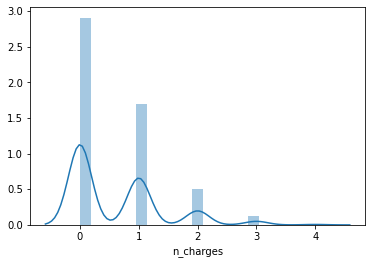

In [43]:
distplot_sampled(features, col='n_charges', sampling_rate=0.01)

<AxesSubplot:xlabel='credit_usage'>

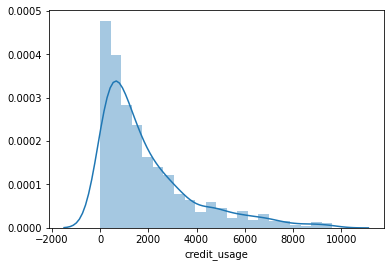

In [44]:
distplot_sampled(features, col='credit_usage', sampling_rate=0.01, without_zero=True, without_outlier=True)

# ビン分割

In [60]:
def bin_large_int(sdf: SDF, col: str, width: int, upper: int) -> SDF:
    """
    整数値を持つ列を等間隔ビンへ分割する。
    col: ビン分割の対象列名
    width: 間隔の幅
    upper: ビンの上限値
    
    ex) width=5, upper=15
    class-0: 0,
    class-1: 1 ~ 5
    class-2: 6 ~ 10
    class-3: 11 ~ 15
    class-4: 16 ~
    
    参考: splitsによるビンは下限含み上限含まず [lower, upper)
    """
    tmp_col = '____tmp____'
    splits = [0, 1] + [i + width + 1 for i in range(0, upper, width)] + [np.inf]
    n_bins = len(splits) - 1
    if n_bins < 10:
        bin_names = ['0'] + [f'{i + 1}_{i * width + 1}~{i * width + width}' for i in range(n_bins - 2)] + [f'{n_bins-1}_{upper + 1}~']
    else:
        bin_names = ['00'] + [f'{i + 1:02d}_{i * width + 1}~{i * width + width}' for i in range(n_bins - 2)] + [f'{n_bins-1:02d}_{upper + 1}~']
    rename_dict = {str(i): v for i, v in enumerate(bin_names)}
    return (
        Bucketizer(splits=splits, inputCol=col, outputCol=tmp_col)
        .transform(sdf)
        .withColumn(col, fn.col(tmp_col).cast('int').cast('string'))
        .drop(tmp_col)
        .replace(rename_dict, subset=[col])
    )


In [61]:
def bin_small_int(sdf: SDF, col: str, upper: int = None) -> SDF:
    """
    カーディナリティの小さい整数値を持つ列をビンへ分割する。
    col: ビン分割の対象列名
    upper: ビンの上限値
    
    ex) upper=3
    class-0: 0
    class-1: 1
    class-2: 2
    class-3: 3
    class-4: 4~
    """
    out = (
        fn.when(fn.col(col) >= upper + 1, fn.lit(f'{upper + 1}~'))
        .otherwise(fn.col(col).cast('string'))
    )
    return sdf.withColumn(col, out)


# 集計

In [62]:
agg = (
    features
    .transform(bin_large_int, col='credit_usage', width=2000, upper=10000)
    .transform(bin_small_int, col='n_charges', upper=3)
    .groupBy('n_charges', 'is_premium', 'credit_usage')
    .agg(
        fn.sum('n_sessions').alias('n_sessions'),
        fn.sum('sales').alias('sales'),
        fn.sum('visit').alias('uu_visit'),
        fn.sum('inflow').alias('uu_inflow'),
    )
    .toPandas()
)

In [5]:
# agg.to_csv('agg.csv', index=False)
agg = pd.read_csv('agg.csv')

In [6]:
class HeatFunnelChart:
    
    def __init__(self, data: DF, funnnels: List[str], heat: Tuple[str, str], heat_name: str = 'heat'):
        self.data = data
        self.funnnels = funnnels
        self.heat = heat
        self.heat_name = heat_name
        self.sum_cols = list(set(list(heat) + funnnels))
    
    def _assign_heat(self, df: DF) -> DF:
        return df.assign(**{
            self.heat_name: df[self.heat[0]] / df[self.heat[1]]
        })
    
    @staticmethod
    def _heat_funnel(x: str, y: str, funnels: List[str], heat: str):
        
        return (x, y, funnels, heat)
    
    def plot_single(self, x: str):
        pdata = self.specify_x(x)
        return self._heat_funnel(x=x, y=None, funnels=self.funnnels, heat=self.heat_name)
    
    def plot_cross(self, x: str, y: str):
        pdata = self.specify_xy(x, y)
        return self._heat_funnel(x=x, y=y, funnels=self.funnnels, heat=self.heat_name)
    
    def specify_x(self, x: str) -> DF:
        return (
            self
            .data
            .groupby(x)[self.sum_cols]
            .sum()
            .reset_index()
            .pipe(self._assign_heat)[[x] + self.funnnels + [self.heat_name]]
        )
    
    def specify_xy(self, x: str, y: str) -> DF:
        return (
            self
            .data
            .groupby([x, y])[self.sum_cols]
            .sum()
            .reset_index()
            .pipe(self._assign_heat)[[x, y] + self.funnnels + [self.heat_name]]
        )

In [7]:
HeatFunnelChart(
    data=agg,
    funnnels=['uu_visit', 'uu_inflow'],
    heat=('sales', 'n_sessions'),
    heat_name='expectation',
).plot_cross(x='n_charges', y='credit_usage')

('n_charges', 'credit_usage', ['uu_visit', 'uu_inflow'], 'expectation')